1. Is there something I can do now to start working on the presentation of my work. Not sure what kind of visuals/charts I can make with NLP analysis other than the word count graphs.
2. Do you have any suggestions on how I can structure my capstone better. 
3. I also have metadata on the movie reviews but I'm not sure how to use it.

count, distribution of length of reviews
distribution of review scores
By Genre
product category

Meta data, recommendation overlap with 'also bought column' 


# 2 Natural Language Processing Analysis

- Author: Jason Truong
- Last Modified: August 21, 2022
- Email: Jasontruong19@gmail.com

# Table of Contents

1. [Objective and Roadmap](#1Objective)  
2. [Preliminary Data Setup](#2Preliminary)  
    2.1. [Preprocessing: 'Overall'](#2_1Overall)  
    2.2. [Preprocessing: 'reviewScore'](#2_2Review)  
    2.3. [Preprocessing: 'Vote'](#2_3Vote)  
    2.4. [Drop duplicates and NaNs](#2_4Drop)  
3. [Test/Train Setup](#4Test_Train)  
4. [NLP Analysis Setup](#3NLP)  
5. [Advanced Models](#5AdvancedModels)  

# 1. Objective and Roadmap<a class ='anchor' id='1Objective'></a>

**Goal #1:** To predict the if the review has a positive or negative sentiment to it. This prediction is related to the prediction overall review score of the product.  
**Goal #2:** Predict if a review will have high or low votes from the community

NLP Roadmap:
1. Tokenize the review text
2. Remove the unnecessary tokens
3. Create a test train data split
4. See if Stemming and Lemmatization is needed
5. Create Models and Evaluate performance

# 2. Preliminary Data Setup<a class ='anchor' id='2Preliminary'></a>

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

Load in the dataset

In [2]:
review_data = []
with open('Movies_and_TV.json','r') as metafile:
    for x in range(2000000):
        review_data.append(json.loads(next(metafile)))

Create the dataframe and explore the data

In [3]:
review_df = pd.DataFrame(review_data)

In [4]:
review_df.info(show_counts= True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 12 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   overall         2000000 non-null  float64
 1   verified        2000000 non-null  bool   
 2   reviewTime      2000000 non-null  object 
 3   reviewerID      2000000 non-null  object 
 4   asin            2000000 non-null  object 
 5   style           1869058 non-null  object 
 6   reviewerName    1999947 non-null  object 
 7   reviewText      1998502 non-null  object 
 8   summary         1999606 non-null  object 
 9   unixReviewTime  2000000 non-null  int64  
 10  vote            413317 non-null   object 
 11  image           2912 non-null     object 
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 169.8+ MB


First step is to only focus on the sentiment of the review to try to predict the overall rating as well as the vote count so every other column will be dropped. A separate analysis will be done to include the summary text if time permits.

In [5]:
# Only keep the necessary columns
review_df = review_df[['overall', 'vote','reviewText','reviewerID','asin']]
review_df

,overall,vote,reviewText,reviewerID,asin
0,5.0,NaN,really happy they got evangelised .. spoiler a...,A3478QRKQDOPQ2,0001527665
1,5.0,3,Having lived in West New Guinea (Papua) during...,A2VHSG6TZHU1OB,0001527665
2,5.0,NaN,Excellent look into contextualizing the Gospel...,A23EJWOW1TLENE,0001527665
3,5.0,NaN,"More than anything, I've been challenged to fi...",A1KM9FNEJ8Q171,0001527665
4,4.0,NaN,This is a great movie for a missionary going i...,A38LY2SSHVHRYB,0001527665
...,...,...,...,...,...
1999995,5.0,NaN,Loved it want to see more,A1UM0LZVGQ4RYX,B0001GF2F6
1999996,5.0,NaN,Loved it wish it was more than two seasons.,A3MWE7P29CDR5L,B0001GF2F6
1999997,5.0,NaN,Such a witty show with good acting. This show ...,A3J6N3SOCENIPB,B0001GF2F6
1999998,4.0,NaN,It's a weird (comical) look at Grim Reapers.,A5O06SYSW6V93,B0001GF2F6


In [6]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 5 columns):
 #   Column      Dtype  
---  ------      -----  
 0   overall     float64
 1   vote        object 
 2   reviewText  object 
 3   reviewerID  object 
 4   asin        object 
dtypes: float64(1), object(4)
memory usage: 76.3+ MB


## 2.1. Check the datatype in the column `overall`<a class ='anchor' id='2_1Overall'></a> 

In [7]:
review_df['overall'].value_counts()

5.0    1304630
4.0     340073
3.0     151321
1.0     123501
2.0      80475
Name: overall, dtype: int64

It looks like the values for the overall column are contained between 1 and 5 which makes sense since its a review out of 5. All of these are also integers so the datatype can be changed to a int8 type. This column represents the review score so it will be renamed for clarity.

In [8]:
review_df['overall'] = review_df['overall'].astype('int8')
review_df.rename(columns={'overall':'reviewScore'}, inplace = True)
review_df

,reviewScore,vote,reviewText,reviewerID,asin
0,5,NaN,really happy they got evangelised .. spoiler a...,A3478QRKQDOPQ2,0001527665
1,5,3,Having lived in West New Guinea (Papua) during...,A2VHSG6TZHU1OB,0001527665
2,5,NaN,Excellent look into contextualizing the Gospel...,A23EJWOW1TLENE,0001527665
3,5,NaN,"More than anything, I've been challenged to fi...",A1KM9FNEJ8Q171,0001527665
4,4,NaN,This is a great movie for a missionary going i...,A38LY2SSHVHRYB,0001527665
...,...,...,...,...,...
1999995,5,NaN,Loved it want to see more,A1UM0LZVGQ4RYX,B0001GF2F6
1999996,5,NaN,Loved it wish it was more than two seasons.,A3MWE7P29CDR5L,B0001GF2F6
1999997,5,NaN,Such a witty show with good acting. This show ...,A3J6N3SOCENIPB,B0001GF2F6
1999998,4,NaN,It's a weird (comical) look at Grim Reapers.,A5O06SYSW6V93,B0001GF2F6


## 2.2 Check the datatype in the column `reviewScore` <a class ='anchor' id='2_2Review'></a>

Split the reviewScore column to 'Good (value of 1)'  for reviews that are 4 or 5 and 'Bad (value of 0)' for reviews that are 1,2 or 3.

In [9]:
review_df['review_class'] = np.where(review_df['reviewScore']>=4,1,0)

In [10]:
review_df.head()

,reviewScore,vote,reviewText,reviewerID,asin,review_class
0,5,NaN,really happy they got evangelised .. spoiler a...,A3478QRKQDOPQ2,0001527665,1
1,5,3,Having lived in West New Guinea (Papua) during...,A2VHSG6TZHU1OB,0001527665,1
2,5,NaN,Excellent look into contextualizing the Gospel...,A23EJWOW1TLENE,0001527665,1
3,5,NaN,"More than anything, I've been challenged to fi...",A1KM9FNEJ8Q171,0001527665,1
4,4,NaN,This is a great movie for a missionary going i...,A38LY2SSHVHRYB,0001527665,1


This new `review_class` column will be used for the logistic regression with the sentiment from the `reviewText`

## 2.3 Check the datatype in the column `Vote`<a class ='anchor' id='2_3Vote'></a>

For the `vote` column, since the NaN values are essentially no votes with can be represented with 0, the NaN values will be replaced with a zero. There are also commas within the vote that causes problems when converted to an int so they will be removed.

In [11]:
review_df['vote'] = review_df['vote'].str.replace(r"\,","",regex = True)
review_df['vote'] = review_df['vote'].fillna(0)
review_df.head()

,reviewScore,vote,reviewText,reviewerID,asin,review_class
0,5,0,really happy they got evangelised .. spoiler a...,A3478QRKQDOPQ2,0001527665,1
1,5,3,Having lived in West New Guinea (Papua) during...,A2VHSG6TZHU1OB,0001527665,1
2,5,0,Excellent look into contextualizing the Gospel...,A23EJWOW1TLENE,0001527665,1
3,5,0,"More than anything, I've been challenged to fi...",A1KM9FNEJ8Q171,0001527665,1
4,4,0,This is a great movie for a missionary going i...,A38LY2SSHVHRYB,0001527665,1


In [12]:
review_df['vote'] = review_df['vote'].astype('int32')
review_df.info(show_counts= True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 6 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   reviewScore   2000000 non-null  int8  
 1   vote          2000000 non-null  int32 
 2   reviewText    1998502 non-null  object
 3   reviewerID    2000000 non-null  object
 4   asin          2000000 non-null  object
 5   review_class  2000000 non-null  int32 
dtypes: int32(2), int8(1), object(3)
memory usage: 62.9+ MB


## 2.4 Drop any duplicates and NaNs in the dataframe <a class ='anchor' id='2_4Drop'></a>

The votes have now all been converted to numbers and the datatype can now be changed.

In [13]:
review_df.drop_duplicates(inplace = True, ignore_index = True)
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1998981 entries, 0 to 1998980
Data columns (total 6 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   reviewScore   int8  
 1   vote          int32 
 2   reviewText    object
 3   reviewerID    object
 4   asin          object
 5   review_class  int32 
dtypes: int32(2), int8(1), object(3)
memory usage: 62.9+ MB


1365 entries has been dropped.

### Remove any NaNs in the dataframe

Check the number of NaN values in the dataframe

In [14]:
review_df.isna().sum()

reviewScore        0
vote               0
reviewText      1497
reviewerID         0
asin               0
review_class       0
dtype: int64

There seems to be 1497 NaN's in the `reviewText` column, since the NLP model is dependent on the `reviewText` those rows will be dropped.

In [15]:
review_df.dropna(inplace = True)
review_df.reset_index(drop=True, inplace= True)
review_df.info(show_counts= True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1997484 entries, 0 to 1997483
Data columns (total 6 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   reviewScore   1997484 non-null  int8  
 1   vote          1997484 non-null  int32 
 2   reviewText    1997484 non-null  object
 3   reviewerID    1997484 non-null  object
 4   asin          1997484 non-null  object
 5   review_class  1997484 non-null  int32 
dtypes: int32(2), int8(1), object(3)
memory usage: 62.9+ MB


The null values have been dropped since the dataframe now only contains 1997484 entries

# 3. Set up Train/Validation/Test split <a class ='anchor' id='4Test_Train'></a>

Since the dataset is 2,000,000 rows, a smaller amount will be sampled for NLP analysis 

In [16]:
review_df.shape

(1997484, 6)

In [17]:
subsample = review_df.sample(frac = 0.05)

# Check results
subsample

,reviewScore,vote,reviewText,reviewerID,asin,review_class
853122,5,0,"all i can say is i must be a knuckle head ,hav...",A3RWAOPZTX9X23,6304366086,1
1549192,5,214,It was Thermopylae. It was the Alamo. It was l...,A1EXS156IQG7OA,B00005JOZI,1
1489712,3,0,it had its moments. I would call this movies c...,A1PHI3A5MHNEWL,B00005JMFQ,0
584779,5,0,Great movie. Came in as expected.,A21G3GPNPGHULA,6303142346,1
870801,5,0,This is a great movie. loved the fact that it ...,A2IEYFQ99D5OJG,6304340532,1
...,...,...,...,...,...,...
1699671,5,0,Must have if you liked the series explains much,A3DKUA65NITXPV,B00006422R,1
1948349,3,28,The movie content is fine if you're a Conan fa...,A19CZ59O4CNDGP,B0000VD12I,0
216209,5,2,Dennis Weaver's masterly portrayal of a pacifi...,A213KRJG67ESPB,6300181987,1
360071,2,0,"My guess is the stars (Jamie Lee Curtis, David...",A3MENXHZSLMX7E,630179821X,0


In [45]:
#Set up data for training, validation and testing
X = subsample.drop(columns = ['review_class', 'reviewScore'])
y = subsample['review_class']

# Stratify ensures that both the train and test set includes all the classes in the data
X_train_val, X_test, y_train_val, y_test = train_test_split(X,y, test_size = 0.25, stratify = y)

# Make the train validation split
X_train, X_validation, y_train, y_validation = train_test_split(X,y, test_size = 0.25, stratify = y)

Check the split of the data for the train and test set

In [46]:
y_train_val.value_counts()/y_train.shape[0]

1    0.821841
0    0.178159
Name: review_class, dtype: float64

The training data contains 82.1% of positive reviews which means that the data is highly skewed towards positive reviews. There is a 82.1% chance of predicting the review sentiment correctly if every prediction made was positive.

In [47]:
y_test.value_counts()/y_test.shape[0]

1    0.821859
0    0.178141
Name: review_class, dtype: float64

The testing data contains 82.1% of positive reviews which means that the data is highly skewed towards positive reviews. There is a 82.1% chance of predicting the review sentiment correctly if every prediction made was positive.

# 4. Set up NLP analysis <a class ='anchor' id='3NLP'></a>

In [48]:
X_train.shape

(74905, 4)

## Convert the text in the reviewText column to vectors

In [49]:
# Instantiate 
# Discard stop words and words need to be in atleast 10 reviews
review_wordbank = CountVectorizer(stop_words = "english", min_df = 10)

# Fit the first 200000 reviews
review_wordbank.fit(X_train['reviewText'])

# 3. Transform
X_train_transformed = review_wordbank.transform(X_train['reviewText'])
X_validation_transformed = review_wordbank.transform(X_validation['reviewText'])
X_test_transformed = review_wordbank.transform(X_test['reviewText'])
X_train_transformed

<74905x16732 sparse matrix of type '<class 'numpy.int64'>'
	with 2063757 stored elements in Compressed Sparse Row format>

After preliminary vectorization with countvectorizer(), 66915 rows of reviews returned 15623 unique terms or tokens.

In [23]:
X_train_transformed.toarray().sum(axis=0)

array([115, 204,  75, ...,  19,  20,  52], dtype=int64)

In [50]:
prelim_df = pd.DataFrame(columns = review_wordbank.get_feature_names(),data = X_train_transformed.toarray())
display(prelim_df)

,00,000,007,01,02,03,04,05,06,07,...,zombie,zombies,zone,zoo,zoom,zoomed,zooming,zorro,zucker,zulu
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74900,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
74901,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
74902,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
74903,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


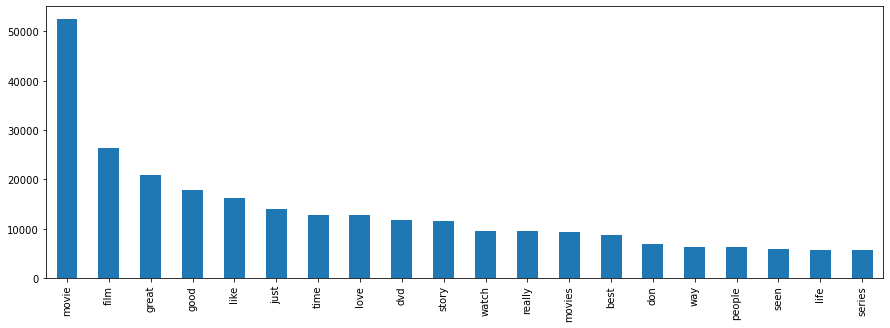

In [25]:
word_counts = pd.DataFrame({"counts":X_train_transformed.toarray().sum(axis=0)},
                          index = review_wordbank.get_feature_names()
                          ).sort_values("counts",ascending= False)

word_counts.head(20).plot(kind="bar",figsize=(15,5), legend = False)

plt.show()

In [37]:
X_train_transformed = X_train_transformed.toarray()
X_test_transformed = X_test_transformed.toarray()

# 5. Advanced Models <a class ='anchor' id='5AdvancedModels'></a>

**REMEMBER TO SCALE THE DATA**

In [38]:
from sklearn.preprocessing import StandardScaler

# Instantiate
standscaler = StandardScaler()
standscaler.fit(X_train_transformed)

X_train_scaled = scaler.transform(X_train_transformed)
X_train_scaled = scaler.transform(y_train_transformed)

KeyboardInterrupt: 

## Logistic Regression

In [35]:
# Instantiate
logreg = LogisticRegression(C = 0.1)

# Fit the model
logreg.fit(X_train_scaled,y_train)

# Score the model
print(f"Train score: {logreg.score(X_train_scaled,y_train)}")
print(f"Test score: {logreg.score(X_test_scaled,y_test)}")

NameError: name 'X_train_scaled' is not defined

## Decision Tree Classification

In [27]:
from sklearn.tree import DecisionTreeClassifier

# Instantiate
decisiontree_model = DecisionTreeClassifier(max_depth = 25)

# Fit the model
decisiontree_model.fit(X_train_transformed,y_train)

# Score the model
print(f"Train score: {decisiontree_model.score(X_train_transformed,y_train)}")
print(f"Test score: {decisiontree_model.score(X_test_transformed,y_test)}")

Train score: 0.8952402301427184
Test score: 0.8377681361691799


## Support Vector Machine Classification

In [42]:
from sklearn.svm import SVC

# Instantiate
svm_model = SVC(kernel='rbf')

# Fit the model
svm_model.fit(X_train_transformed,y_train)

# Score the model
print(f"Train score: {svm_model.score(X_train_transformed,y_train)}")
print(f"Train score: {svm_model.score(X_train_transformed,y_train)}")
print(f"Test score: {svm_model.score(X_test_transformed,y_test)}")

KeyboardInterrupt: 

In [29]:
#review_transformed.toarray().sum(axis=0)

Use grid search to determine the best model and hyperparameter

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

estimators = [('normalize', StandardScaler()),
             ('svm', )]